In [1]:
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

from queue import Queue 
import threading
import gc

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
# from tqdm.notebook import tqdm
from tqdm import tqdm_notebook as tqdm

torch.set_default_dtype(torch.float32)

DEVICE = torch.device("cpu")

In [2]:
import gym
env = gym.make('LunarLander-v2')

/home/ototot/anaconda3/envs/ML/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
class PolicyGradientNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 4)

    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(self.fc2(hid))
        return F.softmax(self.fc3(hid), dim=-1)

In [4]:
class PolicyGradientAgent():

    def __init__(self, network):
        self.network = network
        self.optimizer = optim.SGD(self.network.parameters(), lr=0.001)

    def learn(self, log_probs, rewards):
        loss = (-log_probs * rewards).sum()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def sample(self, state):
        action_prob = self.network(torch.FloatTensor(state).to(DEVICE))
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob

In [5]:
network = PolicyGradientNetwork().to(DEVICE)
agent = PolicyGradientAgent(network)

In [6]:
result = torch.load('PolicyGradient_multithread.pth')

In [7]:
agent.network.load_state_dict(result['model'])

agent.network.train()  # 訓練前，先確保 network 處在 training 模式
EPISODE_PER_BATCH = 64 # 每蒐集 64 個 episodes 更新一次 agent
NUM_BATCH = 300        # 總共更新 300 次

avg_total_rewards, avg_final_rewards = result['avg_total_rewards'], result['avg_final_rewards']

prg_bar = tqdm(range(NUM_BATCH))
prg_bar.set_description(f"Total: ?, Final: ?")

for batch in prg_bar:

    if batch < result['epoch']:
        continue
    
    log_probs, rewards = [], []
    total_rewards, final_rewards = [], []
    
    # 蒐集訓練資料
    def f(result_queue):
        local_log_probs = []
        env = gym.make('LunarLander-v2')
        state = env.reset()
        total_reward, total_step = 0, 0

        while True:

            action, log_prob = agent.sample(state)
            next_state, reward, done, _ = env.step(action)

            local_log_probs.append(log_prob)
            state = next_state
            total_reward += reward
            total_step += 1

            if done:
                result_queue.put((total_reward, total_step, reward, total_reward, local_log_probs))
                del env
                break
    
    result_queue = Queue()
    threads = []
    for i in range(EPISODE_PER_BATCH):
        threads.append(threading.Thread(target=f, args=(result_queue,)))
        threads[-1].start()

    for t in threads:
        t.join()
        total_reward, total_step, reward, total_reward, local_log_probs = result_queue.get()
        final_rewards.append(reward)
        total_rewards.append(total_reward)
        rewards += [total_reward] * total_step
        log_probs += local_log_probs            

    # 紀錄訓練過程
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # 更新網路
    rewards = np.array(rewards, dtype=np.float32)
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # 將 reward 正規標準化
    agent.learn(torch.stack(log_probs).to(DEVICE), torch.from_numpy(rewards).to(DEVICE))
    
    del log_probs, rewards, total_rewards, final_rewards, threads
    
    gc.collect()

In [8]:
result = {
    'epoch': batch,
    'model': agent.network.state_dict(),
    'avg_total_rewards': avg_total_rewards,
    'avg_final_rewards': avg_final_rewards
}
torch.save(result, 'PolicyGradient_multithread.pth')

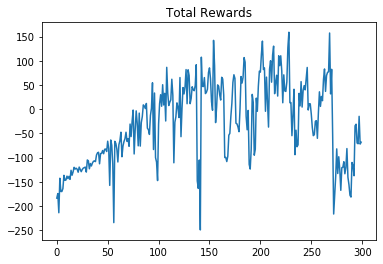

In [9]:
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

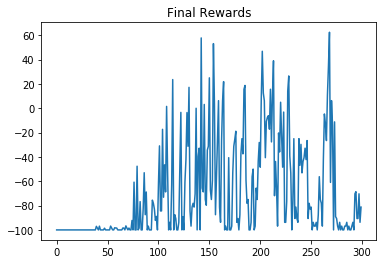

In [10]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()

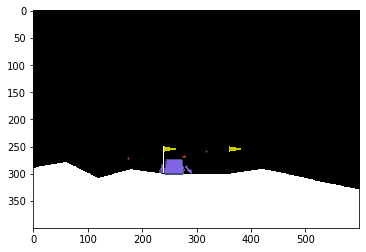

In [11]:
agent.network.eval()  # 測試前先將 network 切換為 evaluation 模式

state = env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

total_reward = 0

done = False
while not done:
    action, _ = agent.sample(state)
    state, reward, done, _ = env.step(action)

    total_reward += reward

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [12]:
print(total_reward, reward)

-45.79966480367429 -100
